In [1]:
import math
import pyproj

import osmnx as ox
import networkx as nx
import rospkg


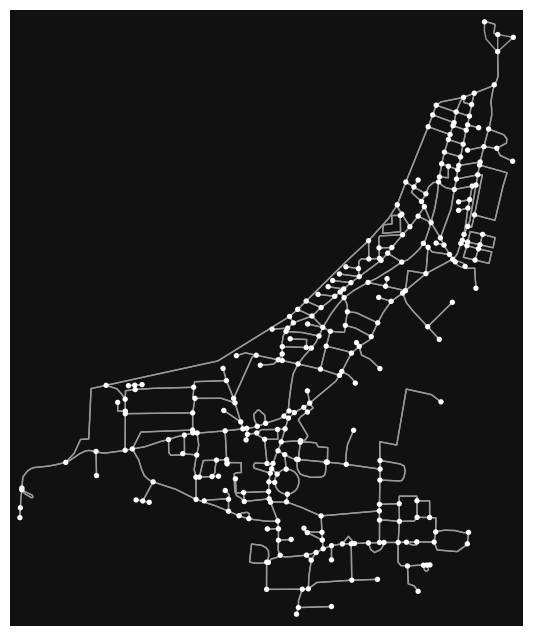

In [2]:
graph_name = "iit_bombay"
# G = ox.graph_from_bbox(28.552709, 28.535328, 77.202061, 77.177380, network_type = 'drive')
G = ox.graph_from_place('IIT Bombay',network_type='bike')
ox.plot_graph(G)
lats = []
longs = []
for n in G.nodes():
    lats.append(G.nodes[n]['y'])
    longs.append(G.nodes[n]['x'])

min_lat = min(lats)
max_lat = max(lats)
min_long = min(longs)
max_long = max(longs)

center = [0.5 * (max_long + min_long), 0.5 * (max_lat + min_lat)]
utm_zone = 1 + math.floor((float(center[0]) + 180)/6)
hemisphere = 'south' if center[1] < 0 else 'north'

projstr = "+proj=utm {} +zone={} +lon_0={} +lat_0={} +x_0=0 +y_0-=0 +ellps=WGS84 +units=m +no_defs".format(hemisphere, utm_zone, center[0], center[1])
projection = pyproj.Proj(projstr)

min_x, min_y = projection(min_long, min_lat)
max_x, max_y = projection(max_long, max_lat)

offset = [0.5 * (max_x + min_x), 0.5 * (max_y + min_y)]


In [3]:
G_nx = nx.DiGraph()
G_nx.add_nodes_from(G.nodes())

for n in G.nodes():
    x, y = projection(G.nodes[n]['x'], G.nodes[n]['y'])
    G_nx.nodes[n]['x'] = x - offset[0]
    G_nx.nodes[n]['y'] = y - offset[1]
    for k in G.nodes[n].keys():
        if k not in ['x', 'y']:
            G_nx.nodes[n][k] = G.nodes[n][k]

for e in G.edges():
    if e[0] != e[1] and not (e[0], e[1]) in G_nx.edges():
        G_nx.add_edge(e[0], e[1])
        G_nx.add_edge(e[1], e[0])
        G_nx[e[0]][e[1]]['length'] = G[e[0]][e[1]][0]['length']
        G_nx[e[1]][e[0]]['length'] = G[e[0]][e[1]][0]['length']
        G_nx[e[0]][e[1]]['shape'] = []
        G_nx[e[1]][e[0]]['shape'] = []
        dist = 0.
        if not 'geometry' in G[e[0]][e[1]][0].keys():
            G_nx[e[0]][e[1]]['shape'].append((G_nx.nodes[e[0]]['x'], G_nx.nodes[e[0]]['y']))
            G_nx[e[0]][e[1]]['shape'].append((G_nx.nodes[e[1]]['x'], G_nx.nodes[e[1]]['y']))
            dist = math.sqrt((G_nx.nodes[e[0]]['x'] - G_nx.nodes[e[1]]['x']) ** 2 + (G_nx.nodes[e[0]]['y'] - G_nx.nodes[e[1]]['y']) ** 2)
            G_nx[e[0]][e[1]]['length'] = dist

        else:
            x_shape = list(G[e[0]][e[1]][0]['geometry'].xy[0])
            y_shape = list(G[e[0]][e[1]][0]['geometry'].xy[1])
            dist = 0.
            for i in range(len(x_shape)):
                long, lat = x_shape[i], y_shape[i]
                x, y = projection(long, lat)
                G_nx[e[0]][e[1]]['shape'].append((x - offset[0], y - offset[1])) 
                if i > 0:
                    dist += math.sqrt((G_nx[e[0]][e[1]]['shape'][-1][0] - G_nx[e[0]][e[1]]['shape'][-2][0]) ** 2 + (G_nx[e[0]][e[1]]['shape'][-1][1] - G_nx[e[0]][e[1]]['shape'][-2][1]) ** 2) 
            G_nx[e[0]][e[1]]['shape'].append((G_nx.nodes[e[1]]['x'], G_nx.nodes[e[1]]['y']))
            dist += math.sqrt((G_nx[e[0]][e[1]]['shape'][-1][0] - G_nx[e[0]][e[1]]['shape'][-2][0]) ** 2 + (G_nx[e[0]][e[1]]['shape'][-1][1] - G_nx[e[0]][e[1]]['shape'][-2][1]) ** 2) 
            G_nx[e[0]][e[1]]['length'] = dist
        
        G_nx[e[1]][e[0]]['shape'] = list(reversed(G_nx[e[0]][e[1]]['shape']))
        G_nx[e[1]][e[0]]['length'] = dist

        list_shape = []
        for i in G_nx[e[0]][e[1]]['shape']:
            list_shape.append('{},{}'.format(i[0], i[1]))
        str_shape = ' '.join(list_shape)
        G_nx[e[0]][e[1]]['shape'] = str_shape

        list_shape = []
        for i in G_nx[e[1]][e[0]]['shape']:
            list_shape.append('{},{}'.format(i[0], i[1]))
        str_shape = ' '.join(list_shape)
        G_nx[e[1]][e[0]]['shape'] = str_shape

In [4]:
#Generate .nod.xml .edg.xml
dir_name = rospkg.RosPack().get_path(name = 'mrpp_sumo')
nx.write_graphml(G_nx, "{}/graph_ml/{}.graphml".format(dir_name, graph_name))

with open('{}/graph_sumo/{}.nod.xml'.format(dir_name, graph_name), 'w') as f:
    f.write('<nodes>\n')
    for n in G_nx.nodes():
        f.write('<node id="{}" x="{}" y="{}" />\n'.format(n, G_nx.nodes[n]['x'], G_nx.nodes[n]['y']))
    f.write('</nodes>')

with open('{}/graph_sumo/{}.edg.xml'.format(dir_name, graph_name), 'w') as f:
    f.write('<edges>\n')
    for e in G_nx.edges():
        f.write('<edge from="{}" to="{}" id="{}to{}" numLanes="1" '.format(e[0], e[1], e[0], e[1]))
        str_shape = G_nx[e[0]][e[1]]['shape']
        f.write('shape="{}" />\n'.format(str_shape))
    f.write('</edges>')

with open('{}/graph_sumo/{}.con.xml'.format(dir_name, graph_name), 'w') as f:
    f.write('<connections>\n')
    for n in G_nx.nodes():
        for e1 in G_nx.in_edges(n):
            for e2 in G_nx.out_edges(n):
                f.write('<connection from="{}to{}" to="{}to{}" />\n'.format(e1[0], e1[1], e2[0], e2[1]))
    f.write('</connections>')




### To generate sumo net file use the following command in terminal
   
   netconvert --node-files=MyNodes.nod.xml --edge-files=MyEdges.edg.xml --connection-files=MyConnections.con.xml --output-file=MySUMONet.net.xml

In [5]:
28.535328, 77.197647

28.544395, 77.177380

28.552709, 77.181774

28.545030, 77.202061

(28.54503, 77.202061)

In [7]:
G_nx = nx.read_graphml('/home/vishwajeet/ddp_workspace/src/mrpp_iot/graph_ml/iit_madras.graphml')
for e in G_nx.edges():
    print(G_nx[e[0]][e[1]])

{'length': 89.52328778346124, 'shape': '1046.6950861508958,1175.9418413317762 980.2436415405245,1115.9533043871634'}
{'length': 66.91890167837936, 'shape': '1046.6950861508958,1175.9418413317762 1046.6950861508958,1175.9418413317762 1037.4711164569017,1177.6171710283961 1004.5856268891948,1183.5766474597622 980.8482320323237,1187.872097331332'}
{'length': 76.80516453590648, 'shape': '940.8960166563629,791.1283519731369 920.7529517119983,717.0116181403864'}
{'length': 188.83087782169187, 'shape': '940.8960166563629,791.1283519731369 945.4244095509639,804.0767152642366 954.3119730622275,849.6268576639704 953.9488504681503,880.6390594006516 951.023561386799,903.4416097807698 956.8920295393327,940.3079002259765 965.5677782346029,976.6570895204786 965.5677782346029,976.6570895204786'}
{'length': 154.59727478329182, 'shape': '940.8960166563629,791.1283519731369 1005.5568966298597,766.6489442002494 1017.9564236499718,749.6687377302442 1016.3520878981217,731.6906052804552 975.2937037062948,710